### Use for Google Colab (not local Jupyter Notebook)

In [2]:
!git clone https://github.com/nitish-nayak/dune-cvn.git

Cloning into 'dune-cvn'...
remote: Enumerating objects: 1447, done.
remote: Counting objects: 100% (343/343), done.
remote: Compressing objects: 100% (335/335), done.
remote: Total 1447 (delta 11), reused 339 (delta 7), pack-reused 1104
Receiving objects: 100% (1447/1447), 89.34 MiB | 21.25 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Checking out files: 100% (339/339), done.


In [3]:
%cd dune-cvn

/content/dune-cvn


In [ ]:
%git checkout nusteam

# CVN Tutorial

In [1]:
%ls

LICENSE           dataset_info/     output/           test_images/
README.md         dune_cvn.ipynb    requirements.txt  utils.py
__pycache__/      modules/          saved_model/


There's a `dataset_info` folder which we will use here that contains 100 events for each of `nueCC`, `numuCC` and `NC`, in a .gz format. Each .gz file is a compressed binary made up of three 500x500 images for the DUNE HD design, with 2 induction planes and 1 collection plane.

To access the truth labels for these events, we will need to read in pickle (`.p`) files. 

## Loading & Plotting pixel maps

In [2]:
# import some useful modules
!cat utils.py
from utils import *

"""
DUNE CVN test module.
"""
__version__ = '1.0'
__author__ = 'Saul Alonso-Monsalve, Leigh Howard Whitehead'
__email__ = "saul.alonso.monsalve@cern.ch, leigh.howard.whitehead@cern.ch"

import shutil

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import numpy as np
import pickle as pk
import sys
import os

sys.path.append(os.path.join(sys.path[0], 'modules'))
sys.path.append(os.path.join('/content/dune-cvn', 'modules'))

from tensorflow.keras.models import model_from_json
from sklearn.metrics import classification_report, confusion_matrix
from skimage.transform import resize
from data_generator import DataGenerator
from opts import get_args
from keras.models import load_model
import my_losses
from dune_cvn import CustomTrainStep

# manually specify the GPUs to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [3]:
# some useful variables for our code
test_values = []
TEST_PARAMS = {'batch_size':1, #batch size for network evaluation (model.predict)
               'images_path':'dataset_info', # folder where all the images lie
               'shuffle':False, # whether we want to shuffle the files (doesn't matter for us, since we're just evaluating them one by one)
               'test_values':test_values}

Here, we'll load the truth labels from the `.p` files. 

In [4]:
# load dataset into IDs, labels 
def get_labels(flav):
  #print('Reading dataset from serialized file...')
  filename = TEST_PARAMS['images_path']+'/'+flav+'/partition_'+flav+'.p'
  with open(filename, 'rb') as partition_file:
      labels = pk.load(partition_file)
      IDs = list(labels.keys())
  #print('Loaded. Number of test examples for flavor %s : %d'%(flav,len(IDs)))
  return IDs, labels

In [5]:
IDs, labels = get_labels('nue') # load pickle file for nueCC events

In [6]:
print(list(labels.keys())[:10])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [7]:
# lookup value for key = '1'
print(labels['1'])

[0, 1, 2, 2, 3, 2, 0]


`labels` is a dictionary that contains the truth information for each event indexed by keys `'0' - '99'`. Remember the CNN has been trained to predict a bunch of information about the topology and not just the flavor. We will only focus on the flavor tagging aspect for now, which is given by the second element of the list

In [8]:
print(labels['1'][1])

1


The second element is enumerated as: 


*   0 - numuCC
*   1 - nueCC
*   2 - nutauCC
*   3 - NC





In [9]:
import zlib
# this function reads the .gz image file given an argument like '0' or '1' or '2' and so on
def get_pixelmap(key, flav): # with a default value
    path = TEST_PARAMS['images_path']+'/'+flav
    with open(path+'/event'+key+'.gz', 'rb') as image_file:
        pixels = np.frombuffer(bytearray(zlib.decompress(image_file.read())), dtype=np.uint8).reshape(3, 500, 500)
        return pixels

In [10]:
def get_eventinfo(key, flav):
    path = TEST_PARAMS['images_path']+'/'+flav
    ret = {}
    with open(path+'/event'+key+'.info', 'rb') as info_file:
        info = info_file.readlines()
        ret['NuPDG'] = int(info[7].strip())
        ret['NuEnergy'] = float(info[1])
        ret['LepEnergy'] = float(info[2])
        ret['Interaction'] = int(info[0].strip()) % 4
        ret['NProton'] = int(info[8].strip())
        ret['NPion'] = int(info[9].strip())
        ret['NPiZero'] = int(info[10].strip())
        ret['NNeutron'] = int(info[11].strip())
        #ret['OscWeight'] = float(info[6])
    return ret

In [11]:
get_pixelmap('3', 'nue')

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

The pixel map is a `3x500x500` array of integers. Each pixel represents the energy deposited, but digitized into a 16-bit integer. Lets try to plot them to see how it looks

In [12]:
import matplotlib.pylab as plt

# useful variable which we use in the code later on
flav_keys=['numucc', 'nuecc', 'nutaucc', 'NC']
# function meant to draw an image. Input here is the image that we obtain from the previous function get_pixelmap
def draw_single_pm(pm):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Pixel Maps')        
    titles = ['U', 'V', 'Z']
    for i in range(3):
        maps = np.swapaxes(pm[i], 0, 1)
        axs[i].imshow(maps, interpolation='none', cmap='twilight')
        axs[i].set_xlabel('Wire')
        axs[i].set_ylabel('TDC')
        axs[i].title.set_text(titles[i])
    plt.show()

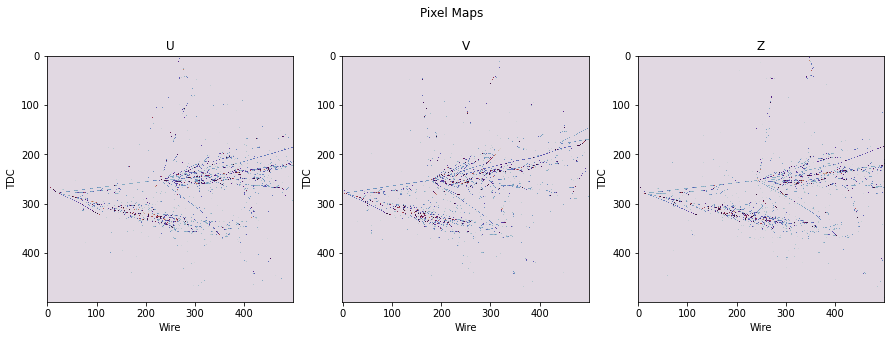

In [13]:
pm = get_pixelmap('3', 'nue')
draw_single_pm(pm)

Here, the x-axis is the `Wire` number associated with that anode-plane. `U` and `V` denoting the induction planes and `Z` denoting the collection. TDC refers to the time tick which is related to the time it takes for the drift electrons to travel to the anode plane from the ionization point. 

We can also look at some relevant information about the event that makes up the image above.

In [14]:
get_eventinfo('3', 'nue')

{'NuPDG': 12,
 'NuEnergy': 26.9497,
 'LepEnergy': 7.9784,
 'Interaction': 2,
 'NProton': 4,
 'NPion': 1,
 'NPiZero': 1,
 'NNeutron': 2}

NuEnergy and LepEnergy denotes the neutrino and lepton energy respectively
The PDG codes denote the type of neutrino where : 

 -  12 (-12) : nue (anti-nue)
 -  14 (-14) : numu (anti-numu)
 -  16 (-16) : nutau (anti-nutau)
 -  1 : NC (since distinguishing the flavor is not possible)

The Interaction codes denote the type of interaction the neutrino had with the nucleus where : 

 - 0 : QuasiElastic (QE)
 - 1 : Delta-Resonance (RES)
 - 2 : Deep Inelastic Scattering (DIS)
 - 3 : Other
 
There is also information about the type and number of important final state particles. Bear in mind, that these numbers have a certain threshold cut, so if for eg a proton in the final state doesn't have enough energy deposits it will not count towards the total

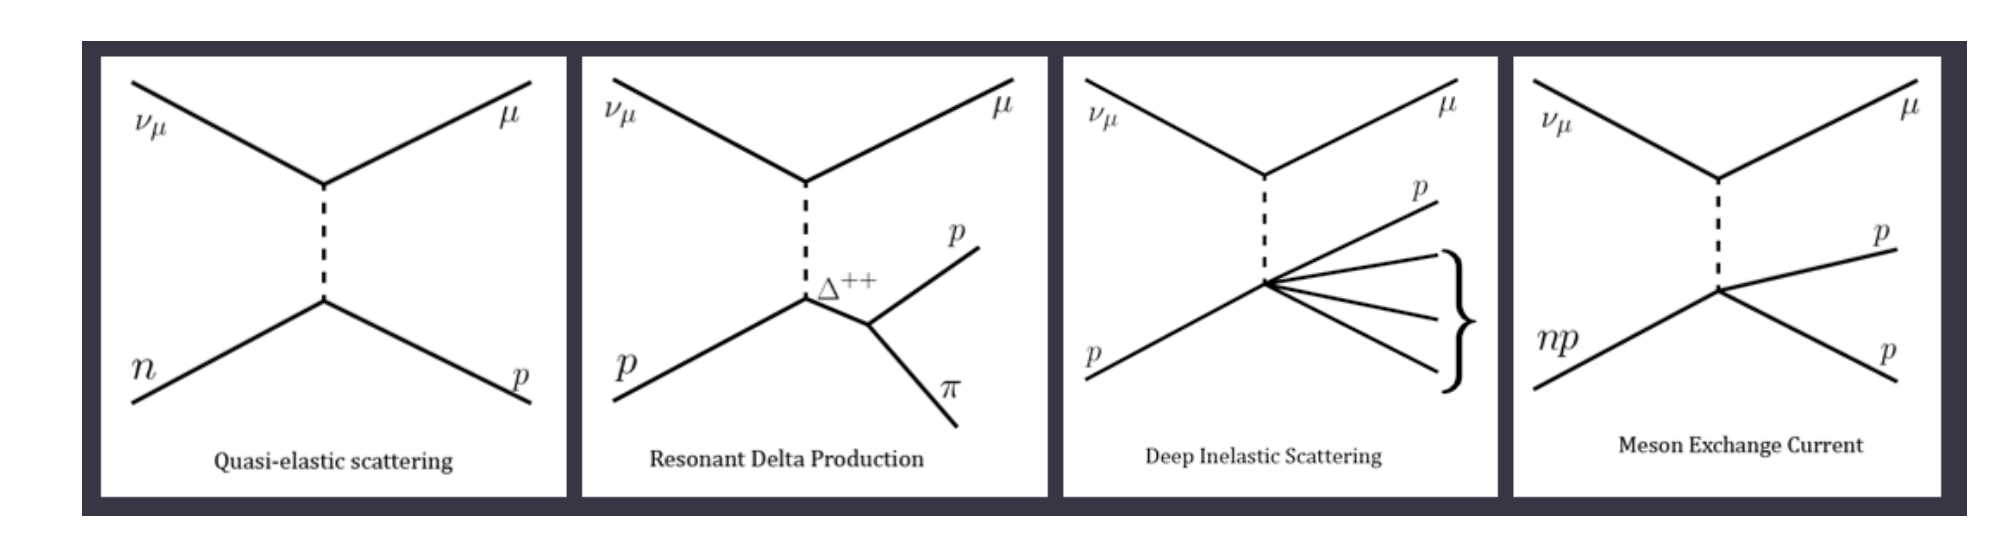

## Running pre-trained model over pixel maps

Now let's try to evaluate our trained network on these images. For that we have to first re-jig the pixel array we got from the `.gz` file into a numpy array format that the network expects. 

In [15]:
# convert image from .gz file (3 images, 500x500 pixels) to some format that the neural network understands
def convert_pm(pm):
    views = len(pm)
    planes = pm.shape[1]
    cells = pm.shape[2]
    
    X = [None]*views
    for view in range(views):
        X[view] = np.zeros((1, planes, cells, 1), dtype='float32')
    for view in range(views):
        X[view][0, :, :, :] = pm[view, :, :].reshape(planes, cells, 1)
    return X

In [16]:
# loads the already trained neural network model for evaluation
def get_model(print_model=False): 
    with open('saved_model/model.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json)
        model.load_weights('saved_model/weights.h5')

    if(print_model):
        model.summary()
    return model
model = get_model() # get the neural network model

2023-07-12 12:51:52.257333: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# return list of flavor scores for each pixel map
def get_scores(pm): 
    scores = model.predict(convert_pm(pm))
    return scores[1]

## Manipulating Images and Evaluating Results from CVN

Let's try to print the results of the network evaluation along with the plot above for a nice summary on what's happening for each event. 

The following code also allows us to manipulate images in ways like : 


*   Flipping - flip the images horizontally and then evaluate the network
*   TurnOff - Turning off one image out of the 3 and see how the network responds to having lesser information. 

But for now, we won't have to worry about this. 



In [18]:
# print results of network evaluation on input image
def print_pminfo(pm, ID, flav):
    print('Results of network evaluation on pixel map')
    scores = model.predict(convert_pm(pm))
    IDs, labels = get_labels(flav)
    flav_score = np.max(scores[1], axis=1)
    flav_pred = np.argmax(scores[1], axis=1)
    print('CVN score for pred label : %f, True Label : %s, Pred Label : %s'%
      (flav_score[0], flav_keys[labels[ID][1]], flav_keys[flav_pred[0]]))
    print('CVN score for true label : ', scores[1][0][labels[ID][1]])
    print('All scores :', scores[1])

# draw image and also print results of network evaluation
# flip = True, False (to flip each image horizontally)
# turnoff = 0, 1 or 2 (to turn off particular images before evaluation)
def show_pminfo(key, flav, flip=False, turnoff=None):
    
    pm = get_pixelmap(key, flav)
    info = get_eventinfo(key, flav)
    pm2 = pm
    if flip:
        #pm2 = np.empty(pm.shape, dtype=np.uint8)
        # flips the image
        for view in range(3):
            pm2[view] = np.flip(pm[view], axis=1)
            
    if turnoff is not None:
        assert (turnoff < 3 and turnoff >= 0), "turnoff can only be 0, 1 or 2"
        pm2[turnoff] = np.zeros(pm[turnoff].shape, dtype=np.uint8)

    draw_single_pm(pm2)
    print_pminfo(pm2, key, flav)
    print("Other info : \n", info)

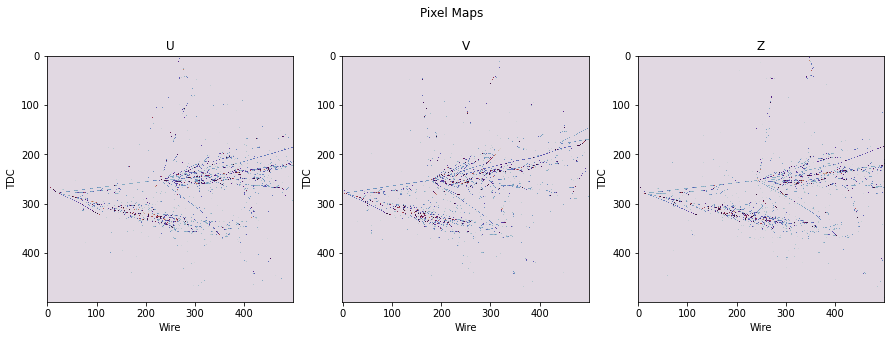

Results of network evaluation on pixel map


2023-07-12 12:51:57.038590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CVN score for pred label : 0.973416, True Label : nuecc, Pred Label : nuecc
CVN score for true label :  0.97341645
All scores : [[5.4426735e-05 9.7341645e-01 2.6350481e-02 1.7872034e-04]]
Other info : 
 {'NuPDG': 12, 'NuEnergy': 26.9497, 'LepEnergy': 7.9784, 'Interaction': 2, 'NProton': 4, 'NPion': 1, 'NPiZero': 1, 'NNeutron': 2}


In [19]:
show_pminfo('3', 'nue', flip=False, turnoff=None)

Here we have: 


*   The predicted label and the true label along with the "likelihood" score the network gives for its prediction
*   In cases where the network gets it wrong, its also useful to see what the score was for the true label
*   Finally, a list of all scores for each of the 4 labels

Let's now try to save the pixel maps as images and then read them back in the format that the network needs to predict the output. Each view is saved as a separate image.

In [20]:
# save as image
from PIL import Image

def convert_8bit(x):
    img_8 = (((x - np.min(x)) / (np.max(x) - np.min(x))) * 255.9).astype(np.uint8)
    ret = Image.fromarray(img_8)
    return ret

def save_pmfig(pm,name='image'):
    titles = ['U', 'V', 'Z']
    for i in range(3):
        maps = convert_8bit(pm[i])
        maps.save('test_images/'+name+'_'+titles[i]+'.png')
        #plt.imsave(name+'_'+titles[i]+'.png',maps)

In [21]:
def read_pmfig(name='image'):
    titles = ['U', 'V', 'Z']
    pm = []
    for i in range(3):
        maps = plt.imread('test_images/'+name+'_'+titles[i]+'.png')
        
        maps_resized = resize(maps, (500,500,1))
        maps_resized.reshape(500, 500)
        maps_resized = (maps_resized - np.min(maps_resized))/(np.max(maps_resized)-np.min(maps_resized))
        maps_resized = maps_resized*255
        maps_resized = maps_resized.astype(np.uint8)
        
        pm.append(maps_resized)
        
    pm = np.array(pm).reshape(3, 500, 500)
    return pm

Save pixel map object we were looking at and read it back into a new object. The read function rescales it to an 8-bit pixel map with values between 0-255. We save these images to `image_U.png`, `image_V.png` and `image_Z.png`

In [23]:
save_pmfig(pm)

Now read back those images without any modifications

In [22]:
pm2 = read_pmfig()

Let's compare between original and new image as a cross-check. Note that there could be some change in information being fed into the network from the new image even here but is expected to be fairly small. Let's now plot the images that we've read without any modifications

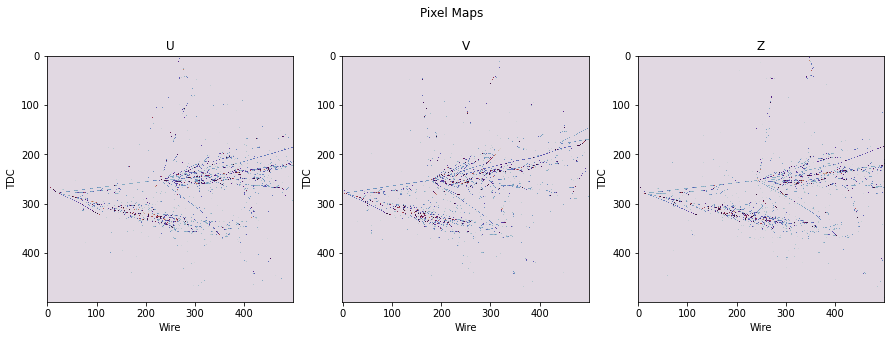

In [23]:
draw_single_pm(pm2)

Let's compare the scores when we don't edit the images locally as a cross-check first.

In [24]:
print("Original Image :", get_scores(pm))
print("Read back Image : ", get_scores(pm2))

Original Image : [[5.4426735e-05 9.7341645e-01 2.6350481e-02 1.7872034e-04]]
Read back Image :  [[5.4426735e-05 9.7341645e-01 2.6350481e-02 1.7872034e-04]]


As expected the scores are nearly identical. Now let's modify the saved images by blocking out one of the showers that is further out from the vertex and looks like it comes from a Pi0. These images are stored locally as `image_modified_U.png` and so on for view `V` and `Z`. 

In [25]:
pm3 = read_pmfig('image_modified')

Let's now plot the new pixel map and print the prediction results as before. Here we've blocked out one of the showers that was further out from the vertex. The resulting image seems by eye to be more nueCC like, but let's evaluate how CVN does on this new pixel map. 

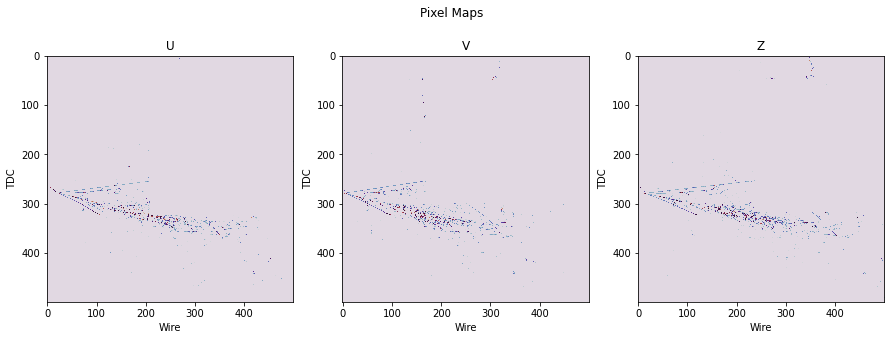

Results of network evaluation on pixel map
CVN score for pred label : 0.970407, True Label : nuecc, Pred Label : nuecc
CVN score for true label :  0.9704075
All scores : [[0.00313829 0.9704075  0.02534399 0.00111022]]


In [26]:
draw_single_pm(pm3)
print_pminfo(pm3, '3', 'nue')

The scores don't change very much even for such a large modification, which is pretty neat validation of the CVN performance in this case!

## Evaluating Performance of CVN

I encourage you to play around with the inputs and see what kind of results you get and try to get a feel for whether the network is behaving accurately and as intended and where its getting confused if at all. But we'll move on to evaluate the network performance more quantitatively. 





In [27]:
# function to get the given label score for each event. 
# For eg, one can ask it to provide the nueCC score for an NC event and so on
def get_flav_score(key, flav, flav_event):
    tags = np.array(['numu', 'nue', 'nutau', 'nc'])
    pm = get_pixelmap(key, flav_event)
    scores = model.predict(convert_pm(pm))
    flav_score = scores[1][0][np.where(tags == flav)[0][0]]

    return flav_score

# function to get the predicted label for input event
def get_pred(key, flav_event):
    pm = get_pixelmap(key, flav_event)
    scores = model.predict(convert_pm(pm))
    flav_pred = np.argmax(scores[1], axis=1)[0]

    return flav_pred

Typically, the first set of numbers we look at in the test dataset are so-called confusion matrices. Essentially a matrix of `True Label` vs `Predicted Label` that tells us where the network gets things wrong and predominantly which label is the most confusing. Here we will ignore `nuTauCC` and just concentrate on `nueCC`, `numuCC` and `NC`

In [32]:
confusion_mat = np.zeros((3,3), dtype=np.uint8)
tags = ['numu', 'nue', 'nc']

#for f in range(3):
#  for i in range(100):
#    flav_pred = get_pred(str(i), tags[f])
#    if(flav_pred == 2) : continue
#    if(flav_pred == 3) : flav_pred = 2
#    confusion_mat[f][flav_pred] += 1

##save
#np.save('numpy_files/confusion_mat.npy', confusion_mat)

#load
confusion_mat = np.load('numpy_files/confusion_mat.npy')

Here, rows are given by True Label, columns by Predicted Label. So one reads this off as, for `100` true numuCC events, the network is able to predict `93` of them accurately. `1` out of `100` is predicted as `nueCC` and `4` as NC. Similarly, one can read off for the other rows as well. Here I've pre-run this code and saved it to a numpy file and read it back. One can uncomment the code block above to re-run it.

In [33]:
print(confusion_mat)

[[93  1  5]
 [ 1 89  4]
 [ 4  5 90]]


We can normalize them by row to get an "efficiency" matrix. Also referred to as "Sensitivity" in other fields. Essentially, for given true label, we ask what fraction is predicted as signal or other background channels. 

In [34]:
eff_mat = confusion_mat/confusion_mat.sum(axis=1,keepdims=True)
print(eff_mat)

[[0.93939394 0.01010101 0.05050505]
 [0.0106383  0.94680851 0.04255319]
 [0.04040404 0.05050505 0.90909091]]


The other side of this is a "purity" matrix. Or "Specificity". Essentially, for a given predicted label, we ask what fraction is actually signal or other background. Sometimes a network can get very good efficiency by predicting a particular label all the time, but that's not a good thing and this metric is designed to catch that. So for eg, we see that the network is able to predict `95%` of `nueCC` accurately and also `94%` of events that it predicts as `nueCC` are actually `nueCC`. 

In [36]:
pur_mat = confusion_mat/confusion_mat.sum(axis=0,keepdims=True)
print(pur_mat)

[[0.94897959 0.01052632 0.05050505]
 [0.01020408 0.93684211 0.04040404]
 [0.04081633 0.05263158 0.90909091]]


We can visualize these numbers better in the following plots. Highly diagonal matrices are a sign that the network is able to generalize to a test dataset (made up of events that it has never seen) pretty well. 

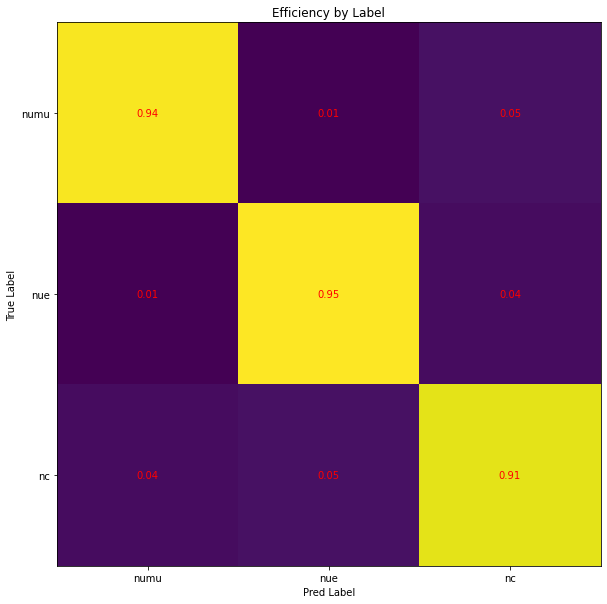

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(eff_mat, interpolation=None)

ax.set_xticks(np.arange(len(tags)))
ax.set_xticklabels(tags)
ax.set_ylabel('True Label')
ax.set_xlabel('Pred Label')
ax.set_yticks(np.arange(len(tags)))
ax.set_yticklabels(tags)
for i in range(len(tags)):
  for j in range(len(tags)):
    text = ax.text(j, i, round(eff_mat[i, j], 2), ha='center', va='center', color='r')

plt.title('Efficiency by Label')
plt.show()

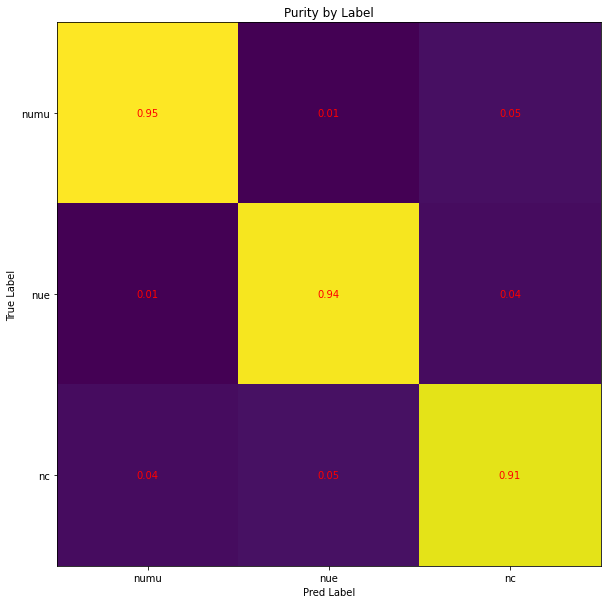

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(pur_mat, interpolation=None)

ax.set_xticks(np.arange(len(tags)))
ax.set_xticklabels(tags)
ax.set_ylabel('True Label')
ax.set_xlabel('Pred Label')
ax.set_yticks(np.arange(len(tags)))
ax.set_yticklabels(tags)
for i in range(len(tags)):
  for j in range(len(tags)):
    text = ax.text(j, i, round(pur_mat[i, j], 2), ha='center', va='center', color='r')

plt.title('Purity by Label')
plt.show()

Let's try to plot some histograms of the network scores to see how much its able to separate signal and background. Here we will look at only `nueCC` scores but as homework, one can make similar plots for `numuCC` and `NC` scores as well. 

In [42]:
# loop over events and append nueCC scores based on whether its signal or background
sig_scores = []
numu_scores = []
nc_scores = []
tags = ['numu', 'nue', 'nc']

'''
for f in range(3):
  for i in range(100):
    flav_score = get_flav_score(str(i), 'nue', tags[f])
    if(f == 1): sig_scores.append(flav_score)
    if(f == 0): numu_scores.append(flav_score)
    if(f == 2): nc_scores.append(flav_score)
sig_scores_n = np.array(sig_scores)
numu_scores_n = np.array(numu_scores)
nc_scores_n = np.array(nc_scores)

#save
np.save('numpy_files/sig_scores.npy', sig_scores_n)
np.save('numpy_files/numu_scores.npy', numu_scores_n)
np.save('numpy_files/nc_scores.npy', nc_scores_n)
'''

#load 
sig_scores_n = np.load('numpy_files/sig_scores.npy')
numu_scores_n = np.load('numpy_files/numu_scores.npy')
nc_scores_n = np.load('numpy_files/nc_scores.npy')

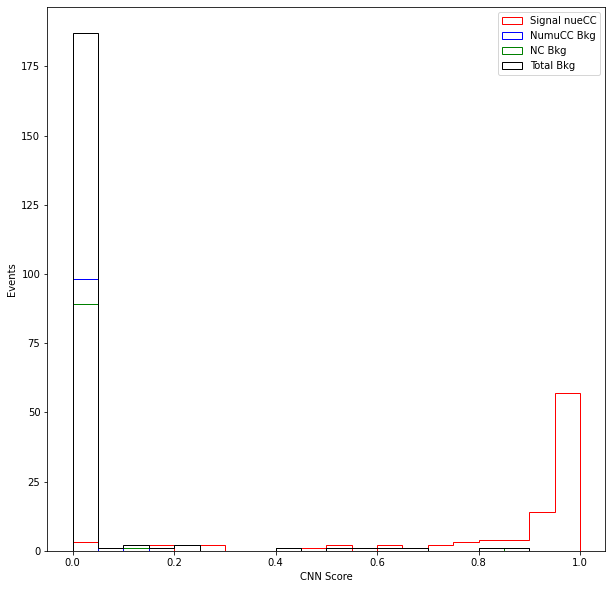

In [43]:
# make the plot
b = np.arange(0, 1.05, 0.05)
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(sig_scores_n, bins=b, histtype='step',color='red',linestyle='solid',label='Signal nueCC')
ax.hist(numu_scores_n, bins=b, histtype='step',color='blue',linestyle='solid',label='NumuCC Bkg')
ax.hist(nc_scores_n, bins=b, histtype='step',color='green',linestyle='solid',label='NC Bkg')
ax.hist(np.append(nc_scores_n,numu_scores_n), bins=b, histtype='step',color='black',linestyle='solid',label='Total Bkg')
ax.legend(loc='best')
ax.set_ylabel('Events')
ax.set_xlabel('CNN Score')
plt.show()

This shows that in terms of the `nueCC` scores, the true `nueCC` events peak near 1 while the background peaks near 0. This shows that the network is behaving appropriately and is able to distinguish signal and background. The better the separation in this plot, the better the performance. 

We can even try to quantify the separation using a "ROC" Curve. 


*   ROC - Receiver Operating Characteristic 

Essentially, it scans across the CNN scores and at each point gathers the fraction of background selected and the fraction of signal selected. Then, it just plots them together. It's instructive to compare this to an extremely dumb classifier which just predicts everything as nueCC without any skill, no matter which event is thrown at it. 




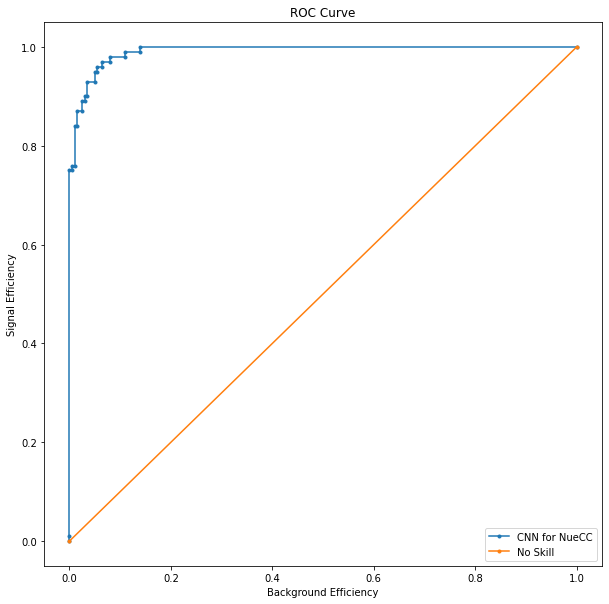

AUC scores for (CNN, No Skill) : 0.991, 0.500


In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

all_scores = np.append(np.append(numu_scores_n, nc_scores_n), sig_scores_n)
lr_fpr, lr_tpr, _ = roc_curve(200*[0] + 100*[1], list(all_scores))
ns_fpr, ns_tpr, _ = roc_curve(200*[0] + 100*[1], 300*[1])
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(lr_fpr, lr_tpr, marker='.', label='CNN for NueCC')
ax.plot(ns_fpr, ns_tpr, marker='.', label='No Skill')
ax.legend(loc='best')
ax.set_title('ROC Curve')
ax.set_xlabel('Background Efficiency')
ax.set_ylabel('Signal Efficiency')
plt.show()
lr_auc = roc_auc_score(200*[0] + 100*[1], list(all_scores))
ns_auc = roc_auc_score(200*[0] + 100*[1], 300*[1])
print('AUC scores for (CNN, No Skill) : %0.03f, %0.03f'%(lr_auc, ns_auc))

One can clearly see that the CNN is obviously far superior to the "No Skill" network that just predicts `nueCC` all the time. The way to quantify this better is to estimate the "Area under the Curve" (AUC) which is one of many possible metrics. The "No Skill" one has an AUC of 0.5 while a CNN has an AUC of 0.998. 

A perfect network will have an AUC of exactly 1, so we can see our CNN is actually very very good! (Of course, there's some influence here of limited statistics, but point still stands.)

One can develop a different network and also compare with this CNN and the No Skill network to see how it performs. The AUC is one metric that can tell us which network is better.